In [1]:
# import libraries
#try:
  # %tensorflow_version only exists in Colab.
#  !pip install tf-nightly
#except Exception:
#  pass
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#!pip install tensorflow-datasets
#import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2023-01-12 19:52:07.444517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0


In [2]:
# get data files
#!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
#!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
import pandas as pd
train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

train = pd.read_csv(train_file_path, sep='\t', header=None)
test = pd.read_csv(test_file_path, sep='\t', header=None)
train.columns = ['label', 'text']
test.columns = ['label', 'text']

del train_file_path, test_file_path


In [3]:
# Exploratory Data Analysis - check missing values
print(train.isna().sum())
print(test.isna().sum())


label    0
text     0
dtype: int64
label    0
text     0
dtype: int64


In [4]:
# Exploratory Data Analysis - value counts
print(train['label'].value_counts(normalize=True))
print(test['label'].value_counts(normalize=True))


ham     0.865997
spam    0.134003
Name: label, dtype: float64
ham     0.865661
spam    0.134339
Name: label, dtype: float64


In [5]:
# Downsampling to balance the dataset
#####################################
import pandas as pd

def downsampling_to_balance(data, label_column):
    value_counts = pd.DataFrame(data[label_column].value_counts())
    unique_labels = value_counts.index
    min_frequency = min(value_counts[label_column])
    downsampled_df = pd.DataFrame()
    for label in unique_labels:
        data_reduced = data[data[label_column] == label]
        data_reduced = data_reduced.sample(n=min_frequency, random_state=123)
        downsampled_df = pd.concat([downsampled_df, data_reduced], ignore_index=True)
    # Shuffle rows
    downsampled_df = downsampled_df.sample(frac = 1).reset_index(drop=True)
    
    return downsampled_df
    
balanced_train_data = downsampling_to_balance(train, 'label')
balanced_test_data = downsampling_to_balance(test, 'label')

# Analize value counts of down sampled dataset
print(balanced_train_data['label'].value_counts())
print(balanced_test_data['label'].value_counts())


ham     560
spam    560
Name: label, dtype: int64
ham     187
spam    187
Name: label, dtype: int64


In [6]:
# Text preprocessing: Data cleaning
###################################
import nltk
#nltk.download('all')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def text_preprocessing(data, text_column):
    # Create a list text
    text = list(data['text'])

    # Preprocessing loop
    lemmatizer = WordNetLemmatizer()

    corpus = []
    for i in range(len(text)):
        r = re.sub('[^a-zA-Z]', ' ', text[i])
        r = r.lower()
        r = r.split()
        r = [word for word in r if word not in stopwords.words('english')]
        r = [lemmatizer.lemmatize(word) for word in r]
        r = ' '.join(r)
        corpus.append(r)

    # Assign corpus to data['text']
    data['text'] = corpus
    
    return data

train = text_preprocessing(data=balanced_train_data, text_column="text")
test = text_preprocessing(data=balanced_test_data, text_column="text")

# Convert "ham" -> 0 and "spam" -> 1
train['label'] = train['label'].replace({"ham": 0, "spam": 1})
test['label'] = test['label'].replace({"ham": 0, "spam": 1})

del stopwords

train.head()


,label,text
0,0,plan family set stone
1,0,fine hope good take care
2,0,barred b q store life twat orange dungerees ca...
3,0,mm feeling sleepy today shall get dear
4,0,joy father john john joy father u an th hav lt...


In [7]:
# Divide into "x" and "y"
train_X = train['text']
test_X = test['text']

train_y = train['label']
test_y = test['label']


In [8]:
# Tokenize train and test datasets
##################################
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 500
max_len = 50

# Training the tokenizer
token=Tokenizer(num_words=vocab_size,oov_token='<OOV>')
token.fit_on_texts(train_X)

# Check if tokenizer worked properly
# token.word_index    

# Generating token embeddings
Training_seq = token.texts_to_sequences(train_X)
Training_pad = pad_sequences(Training_seq,
                                maxlen = max_len,
                                padding = 'post',
                                truncating = 'post')

Testing_seq = token.texts_to_sequences(test_X)
Testing_pad = pad_sequences(Testing_seq,
                            maxlen = max_len,
                            padding = 'post',
                            truncating = 'post')


In [9]:
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create the architecture of the Neural Network
def get_tf_text_classifier(vocab_size=500, output_dim=16, max_len=50):
    model = keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=max_len))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = BinaryCrossentropy(from_logits = False), # Or True?
                metrics = ['accuracy'],
                optimizer = 'adam')
    return model

es = EarlyStopping(patience = 3,
                   monitor = 'val_loss',
                   min_delta = 1e-4,
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       min_delta = 1e-4,
                       factor = 0.5,
                       verbose = 0)


Epoch 1/50


2023-01-12 19:53:36.904209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


35/35 [==============================] - 1s 8ms/step - loss: 0.6915 - accuracy: 0.5661 - val_loss: 0.6877 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.6823 - accuracy: 0.5536 - val_loss: 0.6737 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 0s 3ms/step - loss: 0.6617 - accuracy: 0.6884 - val_loss: 0.6429 - val_accuracy: 0.8155 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: 0.6202 - accuracy: 0.8107 - val_loss: 0.5867 - val_accuracy: 0.8342 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5494 - accuracy: 0.8643 - val_loss: 0.5009 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 0s 4ms/step - loss: 0.4604 - accuracy: 0.9071 - val_loss: 0.4079 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 7/50
35/35 [==============================] - 0s 3ms/step - loss: 0.3688 - accuracy: 0.

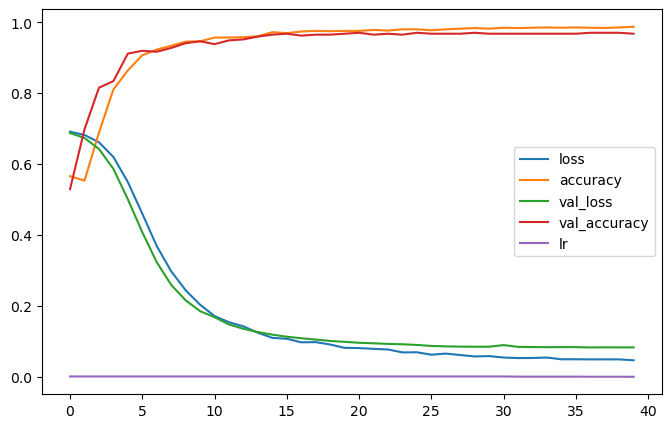

In [10]:
# Initiate model
model = get_tf_text_classifier()

# Train the model
history = model.fit(Training_pad, train_y,
                    validation_data=(Testing_pad, test_y),
                    epochs = 50,
                    verbose = 1,
                    batch_size = 32,
                    callbacks = [lr, es])

# Compute test error
score_test = model.evaluate(x=Testing_pad, y=test_y, verbose=0)

# Print results
print('Train error', history.history['accuracy'][-1])
print('Test error ', score_test[1])

# Plot training and validation history
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


In [11]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])

def predict_message(pred_text):
  # Tokenize
  new_seq = token.texts_to_sequences([pred_text])
  padded = pad_sequences(new_seq, maxlen =50,
                    padding = 'post',
                    truncating='post')
  prediction = model.predict(padded)
  prediction = prediction[0][0]
  return [prediction, "ham" if prediction < 0.5 else "spam"]

pred_text =  "sale today! to stop texts call 98912460324?"

prediction = predict_message(pred_text)

print(prediction)


1/1 [==============================] - 0s 111ms/step
[0.6635248, 'spam']


In [12]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 17ms/step
You passed the challenge. Great job!
